# Stack LSTM for Time Series Prediction
In time series prediction, the goal is to predict the future values based on past observation which consists of intrinsic patterns. To determine a model that expresses the pattern of the time series, we need a model to describe the important features of the time series pattern and explain how the past affects the future or how two-time series can “interact”.  In this noteboo, I want to predict the future value of Bitcoin using Stack LSTM and compare it with Seq2Seq model in terms of MAPE.

## How to use this ".ipynb" Python notebook ?

To run the notebook, you must have installed Jupyter Notebook or iPython Notebook. To open the notebook, you must write `jupyter notebook` or `iPython notebook` in command line (from the folder containing the notebook once downloaded, or a parent folder). It is then that the notebook application (IDE) will open in your browser as a local server and it will be possible to open the `.ipynb` notebook file and to run code cells with `CTRL+ENTER` and `SHIFT+ENTER`, it is also possible to restart the kernel and run all cells at once with the menus. Note that this is interesting since it is possible to make that IDE run as hosted on a cloud server with a lot of GPU power while you code through the browser.

## Problem Statment

This project is created to predict the future value of the Bitcoin's price. The data that we used is the daily market data of the bitcoin's value, consits of BTC/USD and BTC/EUR. The goal of this project is to predict one week of bitcoin price using Seq2Seq network. We can imporve the result by adding more data for example the stock market data.

## Data Set and Input of Network
I created a python code to read the dataset and convert it into past and future window and also batch the data in "utils_Bitcoin.py". I imported the generator function from this dataset as "generate_x_y_data". The inputs of this generator are "Status" can be "Train", "Validation" or "Test". Other inputs are "batch_size", "past_window", and "future_window" which are the size of the batch, how much data in the past we use to slide the data, and how many steps we will predict in future, respectively.  

In the "dataset_bitcoin.py" file, first I read the data from http://api.coindesk.com/v1/bpi/historical/close.json?start=2010-07-17&end=2017-03-03 
and then concatanate the both value of bitcoin in terms of "USD" and "EUR". Next, I window the data based on the past_window and future_window. After that, I normalized the data I passed the data based on the batch size. In this notebook, I the data created as a generator to feed the keras model.  


In [1]:
from dataset_bitcoin import generate_x_y_data

In [2]:

import keras 
import numpy as np
import matplotlib.pyplot as plt

# This is for the notebook to generate inline matplotlib 
# charts rather than to open a new window every time: 
%matplotlib inline


Using TensorFlow backend.


## Neural network's hyperparameters

In [3]:
keras.backend.clear_session()

num_input_features = 2 # The dimensionality of the input at each time step. In this case a 1D signal.
num_output_features = 2 # The dimensionality of the output at each time step. In this case a 1D signal.

past_window = 7  # Length of the sequence used by the input
future_window = 7 # Length of the sequence we predict in future

# Internal neural network parameters
layers = [100, 100] # Number of hidden neuros in each layer of the encoder and decoder
steps_per_epoch =14 # How many times in each iteration we train
batch_size = 100

# Regularisation isn't really needed for this application
lambda_regulariser = 0.000001 # Will not be used if regulariser is None
regulariser = None # Possible regulariser: keras.regularizers.l2(lambda_regulariser)

loss = "mse"
output_dim = input_dim = 2  # Output dimension (e.g.: multiple signals at once, tied in time)

# Optmizer: 
learning_rate = 0.007
decay = 0 # Learning rate decay
optimiser = keras.optimizers.Adam(lr=learning_rate, decay=decay) # Other possible optimiser "sgd" (Stochastic Gradient Descent)
learning_rate = 0.00001  # Small lr helps not to diverge during training. 
epochs = 100

## Define the network model 

In [4]:
# input of the lstm network
inputs = keras.layers.Input(shape=(None, input_dim))

stack_cells = []
for hidden_neurons in layers:
    stack_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))

output_LSTM = keras.layers.RNN(stack_cells, return_sequences=True, return_state=True)

outputs_and_states = output_LSTM(inputs)

# Only select the output (not the states)
outputs = outputs_and_states[0]

# Apply a dense layer with linear activation to set output to correct dimension
# and scale (tanh is default activation for GRU in Keras, our output sine function can be larger then 1)
dense_layer = keras.layers.Dense(num_output_features,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser)

reshaped_outputs = dense_layer(outputs)


In [5]:
model = keras.models.Model(inputs=inputs, outputs=reshaped_outputs)
model.compile(optimizer=optimiser, loss=loss)

In [6]:
train_data_generator = generate_x_y_data(isTrain=True, batch_size=batch_size, steps_per_epoch = steps_per_epoch,
                                         past_window = past_window, future_window = future_window)

model.fit_generator(train_data_generator, steps_per_epoch=steps_per_epoch, epochs=epochs)


Epoch 1/100
14/14 [==============================] - 5s 338ms/step - loss: 3.4919
Epoch 2/100
14/14 [==============================] - 3s 196ms/step - loss: 3.2858
Epoch 3/100
14/14 [==============================] - 3s 199ms/step - loss: 3.1106
Epoch 4/100
14/14 [==============================] - 3s 209ms/step - loss: 3.6754
Epoch 5/100
14/14 [==============================] - 3s 204ms/step - loss: 3.1287
Epoch 6/100
14/14 [==============================] - 3s 233ms/step - loss: 3.4566
Epoch 7/100
14/14 [==============================] - 3s 205ms/step - loss: 3.2248
Epoch 8/100
14/14 [==============================] - 3s 202ms/step - loss: 2.9897
Epoch 9/100
14/14 [==============================] - 3s 203ms/step - loss: 3.5074
Epoch 10/100
14/14 [==============================] - 3s 210ms/step - loss: 3.3967
Epoch 11/100
14/14 [==============================] - 3s 203ms/step - loss: 3.2635
Epoch 12/100
14/14 [==============================] - 3s 213ms/step - loss: 3.0087
Epoch 13/100

14/14 [==============================] - 3s 230ms/step - loss: 3.6339
Epoch 98/100
14/14 [==============================] - 3s 233ms/step - loss: 2.9306
Epoch 99/100
14/14 [==============================] - 3s 211ms/step - loss: 3.1597
Epoch 100/100
14/14 [==============================] - 3s 212ms/step - loss: 3.4686


In [7]:
test_data_generator = generate_x_y_data(isTrain=False, batch_size=batch_size, steps_per_epoch = steps_per_epoch,
                                         past_window = past_window, future_window = future_window)

x_test, y_test = next(test_data_generator) # x_decoder_test is composed of zeros.

y_test_predicted = model.predict(x_test)

In [8]:
test_data_generator = generate_x_y_data(isTrain=False, batch_size=batch_size, steps_per_epoch = steps_per_epoch,
                                         past_window = past_window, future_window = future_window)

x_test, y_test = next(test_data_generator)

(7, 100, 2)
-0.024684704571974102


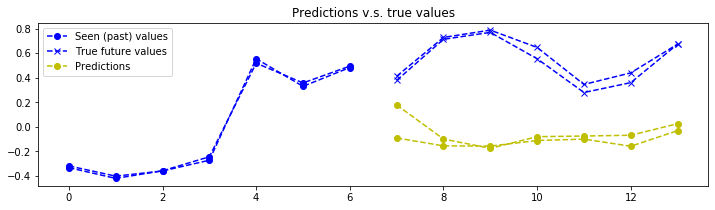

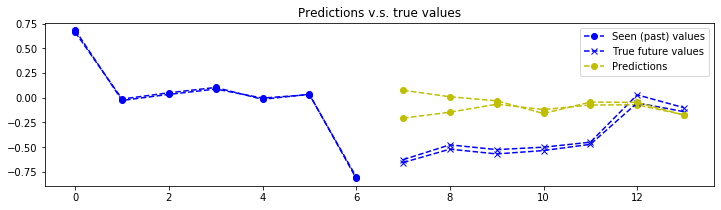

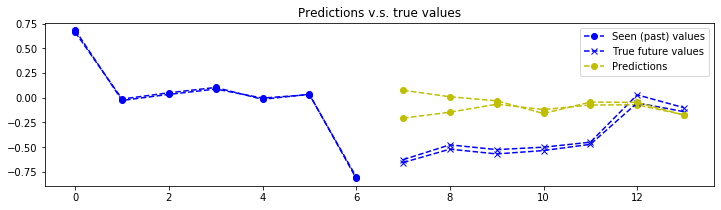

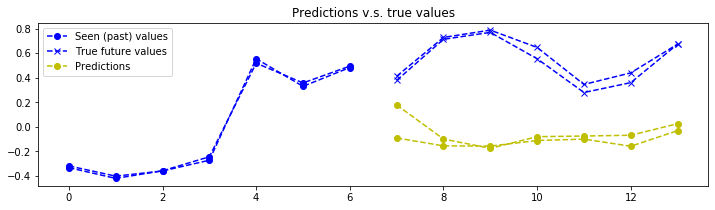

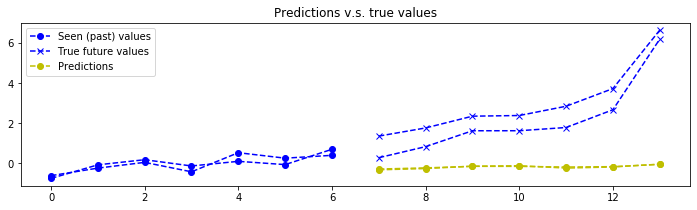

In [18]:
from utils import plot_prediction
import tensorflow as tf


num_steps_to_predict = 5
y_test_predicted =  model.predict(x_test)
print(y_test.shape)
# Select 10 random examples to plot
indices = np.random.choice(range(x_test.shape[0]), replace=True, size=5)
MAPE = (1/batch_size)*((y_test_predicted.transpose(1,0,2)- y_test.transpose(1,0,2))/y_test.transpose(1,0,2))
print(np.mean(MAPE))
for index in indices:
    plot_prediction(x_test[:,index, :], y_test[:,index, :], y_test_predicted[:,index, :])
  

### The average of The mean error in this method is 2.4%

In [24]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown Udacity-Capstone-seq2seq-final.ipynb
!mv Udacity-Capstone-seq2seq-final.md README.md

[NbConvertApp] Converting notebook Udacity-Capstone-seq2seq-final.ipynb to markdown
[NbConvertApp] Support files will be in Udacity-Capstone-seq2seq-final_files/
[NbConvertApp] Making directory Udacity-Capstone-seq2seq-final_files
[NbConvertApp] Making directory Udacity-Capstone-seq2seq-final_files
[NbConvertApp] Making directory Udacity-Capstone-seq2seq-final_files
[NbConvertApp] Making directory Udacity-Capstone-seq2seq-final_files
[NbConvertApp] Making directory Udacity-Capstone-seq2seq-final_files
[NbConvertApp] Making directory Udacity-Capstone-seq2seq-final_files
[NbConvertApp] Writing 24661 bytes to Udacity-Capstone-seq2seq-final.md
